In [2]:
import sys
sys.path.insert(0, '/tf/utils/')

In [8]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Attention, Add, BatchNormalization, Lambda, Activation, Multiply, Dense, Flatten, Input, Concatenate, concatenate, UpSampling2D, LayerNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, Conv2DTranspose
from tensorflow import keras
from keras.callbacks import Callback
from utils import add_white_gaussian_noise, somar_sinais, performance

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import stft, istft
import librosa
from datetime import datetime
from IPython import display

from sound import Sound

In [9]:
base_shape_size = 8192
ws = 255
ol = 128
NORM_FACTOR = 128

In [73]:
def calculate_mel_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    # Calcula o espectrograma de Mel a partir do sinal de áudio
    mel = librosa.feature.melspectrogram(y=signal, sr=sampling_rate, n_fft=window_size, hop_length=overlap, n_mels=128)
    
    # # Calcula o módulo e a fase do espectrograma de Mel
    # magnitude, phase = librosa.magphase(mel)

    # phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(mel.shape[1]), sr=sampling_rate, hop_length=overlap)

    return mel, f, t

def reconstruct_signal_from_mel(magnitude, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    mel = magnitude #* np.exp(1j * phi)
    
    # Inversa a transformada de Mel para obter o sinal de áudio
    signal = librosa.feature.inverse.mel_to_audio(mel, n_fft=window_size, hop_length=overlap)

    return signal

In [12]:
sound_base = Sound('../../Dados/Vozes/', '../../Dados/Ruido/', base_shape_size, limit=100)

Loading Speech Files: 100%|██████████| 100/100 [00:00<00:00, 750.14it/s]


In [74]:
s = sound_base.train_X[0]

In [75]:
min_valor = np.min(s)
max_valor = np.max(s)

# Defina o novo intervalo desejado
novo_min = -0.4
novo_max = 0.4

# Realize a escala do sinal para o novo intervalo
sound_escalado = (s - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min

In [76]:
A, _, _ = calculate_mel_magnitude_and_phase(s)

In [77]:
A.shape

(128, 64)

In [78]:
sig = reconstruct_signal_from_mel(A)

In [79]:
Audio(data=s, rate=8000)

In [80]:
Audio(data=sig, rate=8000)

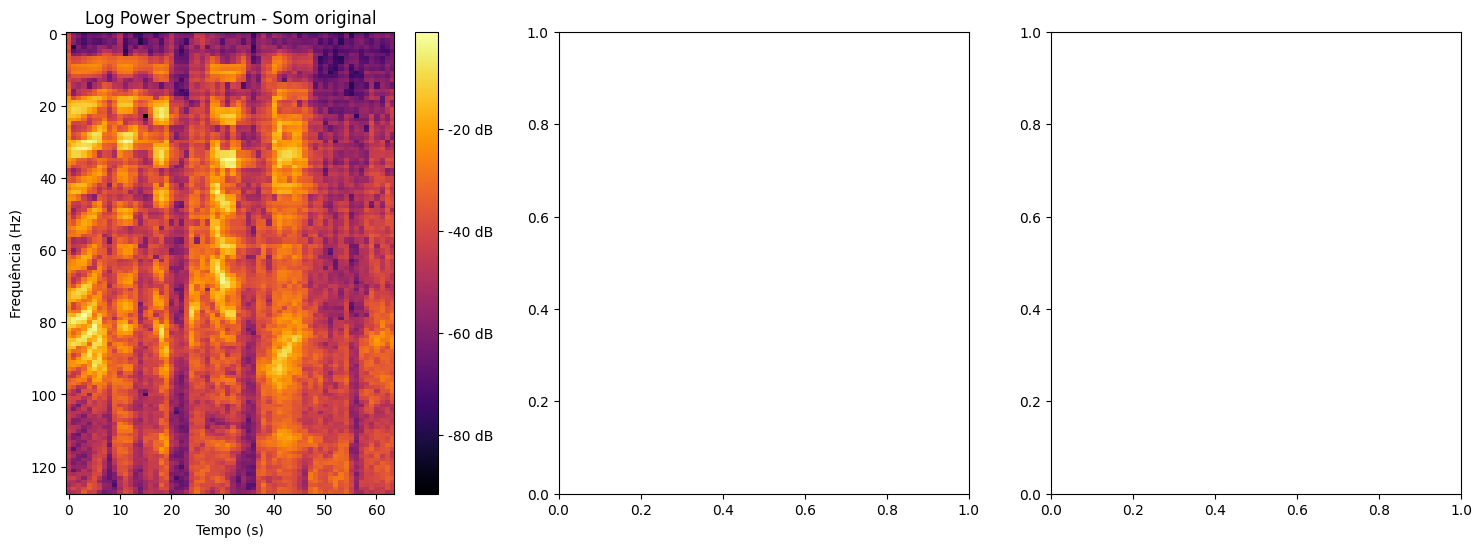

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Uma linha com três subplots

# Primeiro gráfico
im = axs[0].imshow(10*np.log10(A), aspect='auto', cmap='inferno')
axs[0].set_title('Log Power Spectrum - Som original')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Frequência (Hz)')
fig.colorbar(im, ax=axs[0], format='%+2.0f dB')

<function matplotlib.pyplot.show(close=None, block=None)>

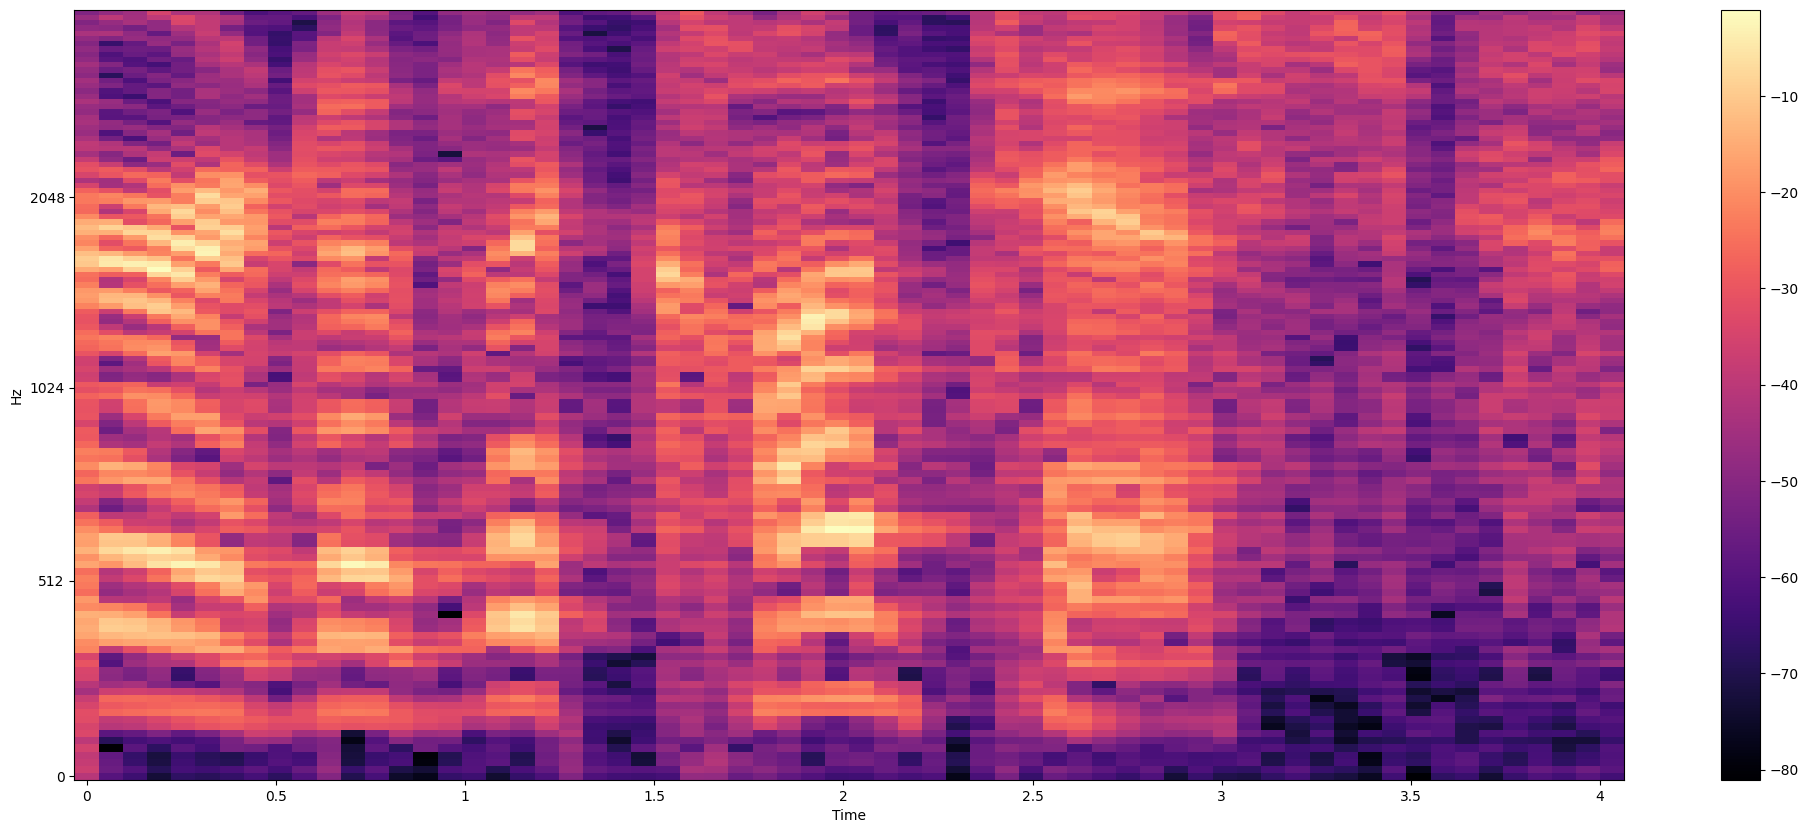

In [51]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(
            # librosa.feature.melspectrogram(y=s, sr=8000, n_fft=ws, hop_length=ol, n_mels=128),
            librosa.power_to_db(librosa.feature.melspectrogram(y=s, sr=8000, n_fft=ws, hop_length=ol, n_mels=128)),
            x_axis='time',
            y_axis='mel',
            sr=8000)
plt.colorbar()
plt.show

/tmp/ipykernel_1727/4148300391.py:4: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.power_to_db(librosa.stft(s, n_fft=ws, hop_length=ol)),


<function matplotlib.pyplot.show(close=None, block=None)>

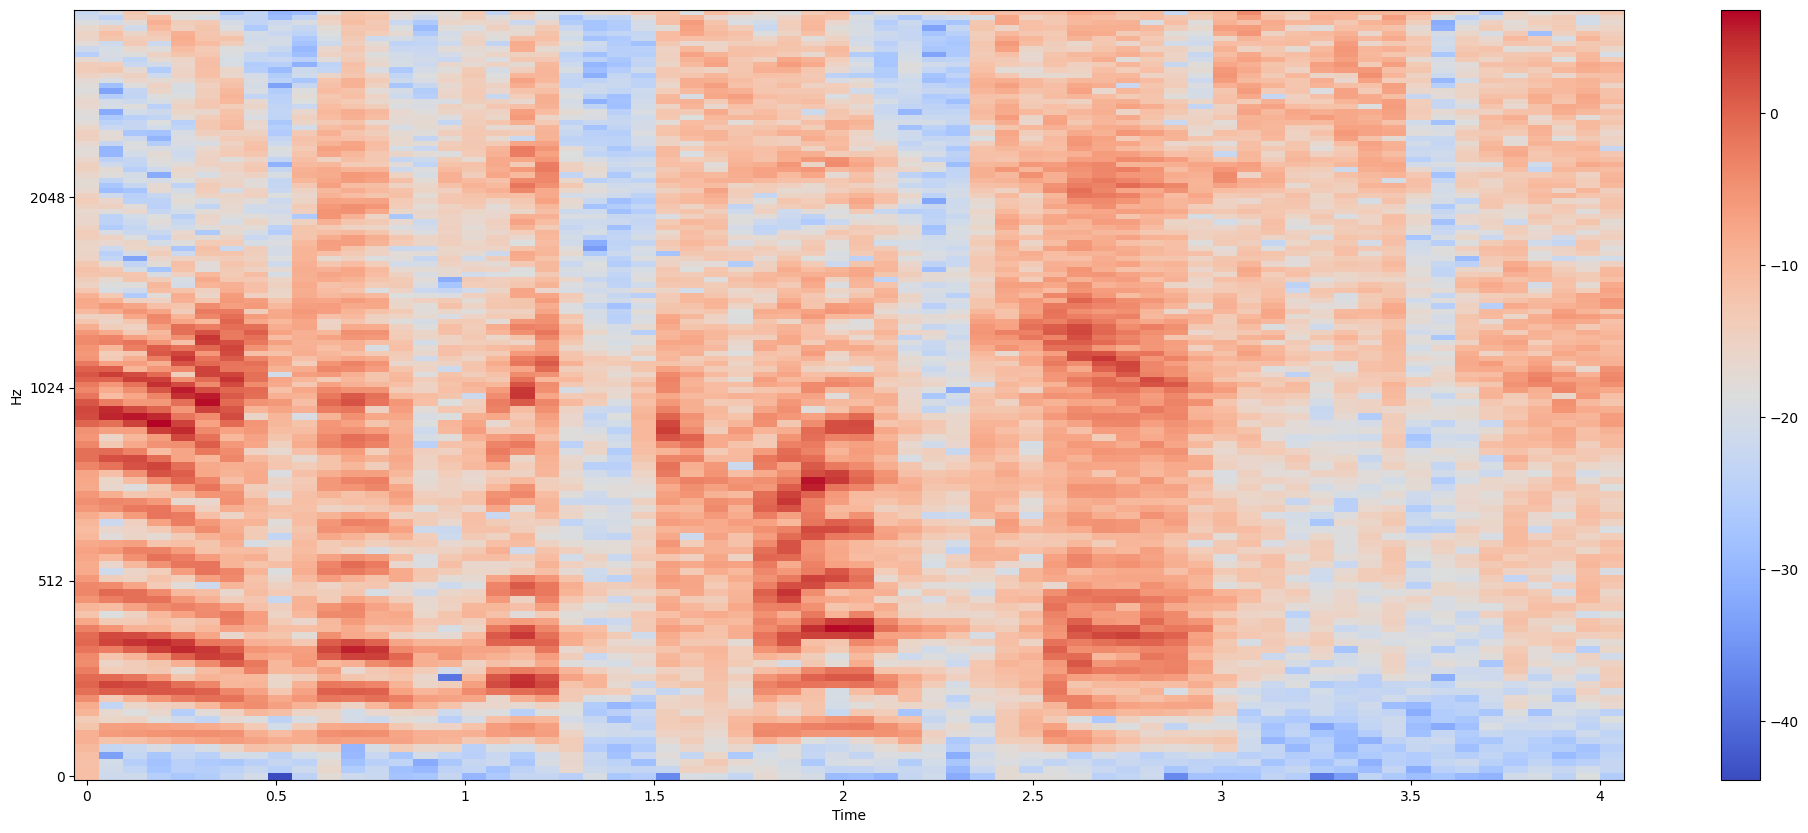

In [50]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(
            # 20 * np.log10(librosa.stft(s, n_fft=ws, hop_length=ol)),
            librosa.power_to_db(librosa.stft(s, n_fft=ws, hop_length=ol)),
            x_axis='time',
            y_axis='mel',
            sr=8000)
plt.colorbar()
plt.show